In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from helperFunctions import createDataSet, prepare_features_target
import os

In [2]:
year = 2020
file_num = 1
DATA_PATH = f"/Users/nathanhoffman/Library/Mobile Documents/com~apple~CloudDocs/UniBe/3. Semester/Data Driven Diabetes Management/DDDM-Project7/data/Ohio{year}_processed/train"
files = os.listdir(DATA_PATH)
file = files[file_num]
train_set_list, scaler = createDataSet(os.path.join(DATA_PATH, file))
# Remove duplicates
train_set_list = [train_set_list[x] for x, _ in enumerate(train_set_list) if train_set_list[x].equals(train_set_list[x-1]) is False]
train_set = pd.concat(train_set_list)

DATA_PATH = f"/Users/nathanhoffman/Library/Mobile Documents/com~apple~CloudDocs/UniBe/3. Semester/Data Driven Diabetes Management/DDDM-Project7/data/Ohio{year}_processed/test"
files = os.listdir(DATA_PATH)
file = files[file_num]
test_set_list, scaler = createDataSet(os.path.join(DATA_PATH, file), scaler=scaler)
# Remove duplicates
test_set_list = [test_set_list[x] for x, _ in enumerate(test_set_list) if test_set_list[x].equals(test_set_list[x-1]) is False]
test_set = pd.concat(test_set_list)

print(f"Length of train set: {len(train_set_list)}")
print(f"Length of test set: {len(test_set_list)}")

Length of train set: 2
Length of test set: 4


In [3]:
def subsample_df(df, start=0, stop=-1, subsamples = 1):
    df = pd.concat([df[start:stop:subsamples], df.tail(1)])
    return df

def reconstruct_samples(df, numOfValues, interpolation = "interp1d"):
    x = df.index.values
    y = df.values
    if interpolation == "interp1d":
        f = interpolate.interp1d(x, y)
    elif interpolation == "cubicspline":
        f = interpolate.CubicSpline(x, y)

    xnew = np.arange(x[0], x[-1]+1, numOfValues)
    ynew = f(xnew)
    return xnew, ynew

def create_statistics(df, reconstruction):
    length = len(reconstruction) if len(df) > len(reconstruction) else len(df) 
    mse = np.mean((df[:length].values - reconstruction[:length])**2)
    return mse

def create_standard_metrics(train_set: list):
    total_stats = {}

    train_cbg = pd.concat(train_set).cbg
    true_mean = train_cbg.mean()
    true_std = train_cbg.std()
    
    subsampling = [1, 2, 4, 8, 16, 32]
    mse_list = []
    interpolation = "cubicspline"

    def create_dict(mean, std, times, mse = None):
        dictonary = {"Mean": mean,
                "Std": std,
                "Times": times}
        if mse:
            dictonary["MSE"] = mse

        # Transform the dictionary
        times_data = dictonary.pop("Times")  # Remove "Times" and get its dictionary
        dictonary.update(times_data)        # Add the key-value pairs from "Times"
        return dictonary
    
    def create_times(s):
        times = {
            "Time in range (70-180)" : len(s[(s >= 70) & (s <= 180)])/len(s),
            "Time in tight range (70-140)" : len(s[(s >= 70) & (s <= 140)])/len(s),
            "Time in low (<70)" : len(s[(s < 70)])/len(s),
            "Time in very low (<54)" : len(s[(s < 54)])/len(s),
            "Time in high (>180)" : len(s[(s > 180)])/len(s),
            "Time in very high (>250)" : len(s[(s > 250)])/len(s),
        }

        return times
    true_times = create_times(train_cbg)

    total_stats["True"] = create_dict(true_mean, true_std, true_times)

    for sub in subsampling:
        recon_list = []
        for i, data in enumerate(train_set):
            data = data.cbg
            subsampled_values = subsample_df(data, start=0, stop=-1, subsamples=sub)
            samples_reconstructed = reconstruct_samples(subsampled_values, 1, interpolation)

            recon_list.append(pd.Series(samples_reconstructed[1]))

            if i % 106 == 0:
                plt.figure()
                plt.plot(data.index.values*5/60, data)
                plt.plot(samples_reconstructed[0]*5/60, samples_reconstructed[1], '--')
                plt.xlabel("Time [h]")
                plt.ylabel("CBG [mg/dl]")
                plt.title(f"{interpolation} Subsampling rate: {sub}")

            mse = create_statistics(data, samples_reconstructed[1])
            mse_list.append(mse)
        recon = pd.concat(recon_list)
        recon_mean = recon.mean()
        recon_std = recon.std()
        recon_times = create_times(recon)
        total_stats[f"Subsampling rate {sub}"] = create_dict(recon_mean, recon_std, recon_times, mse)


    return total_stats

Length of train set: 59
Sample 13534 is out of range
Length of train set: 128
Length of train set: 48


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_83736/114846545.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Length of train set: 10
Length of train set: 105
Sample 12128 is out of range
Length of train set: 110
Length of train set: 13
Length of train set: 2
Length of train set: 2
Length of train set: 2
Sample 13199 is out of range
Length of train set: 90
Sample 14036 is out of range
Length of train set: 17


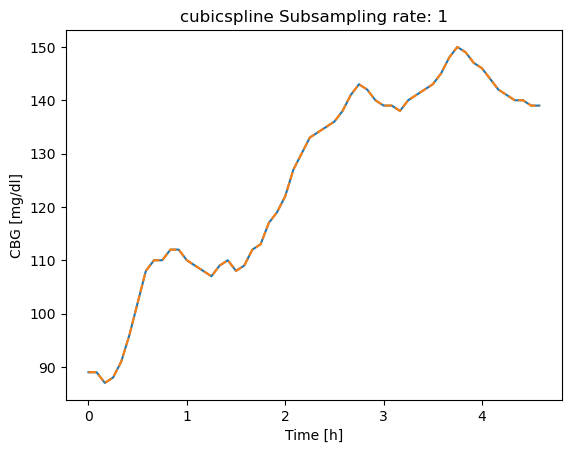

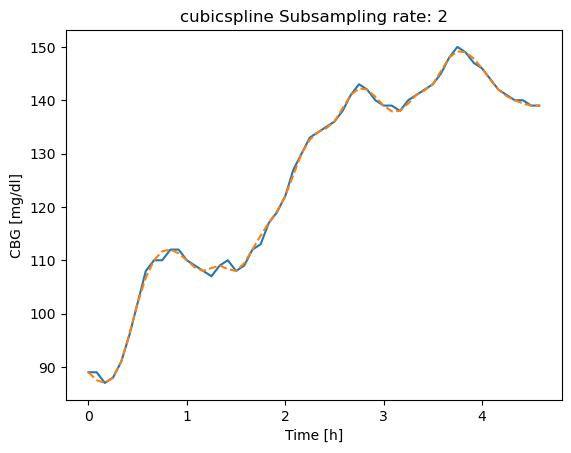

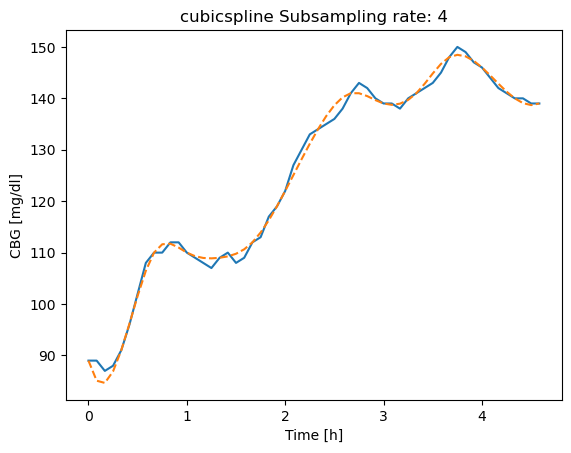

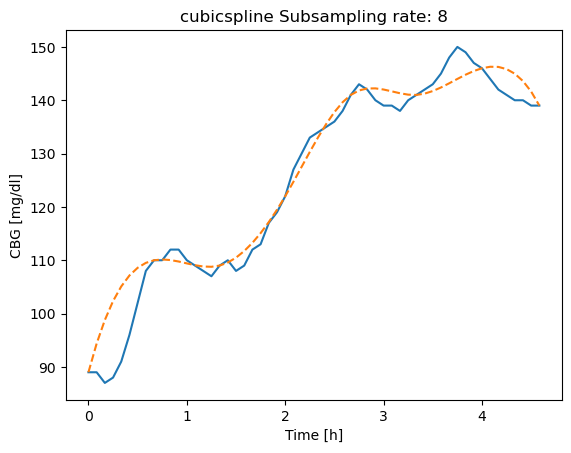

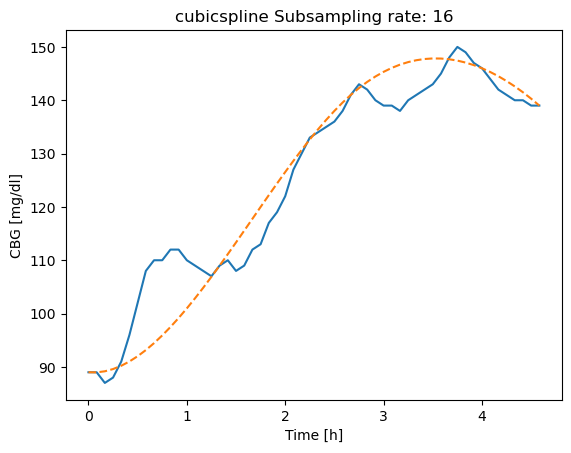

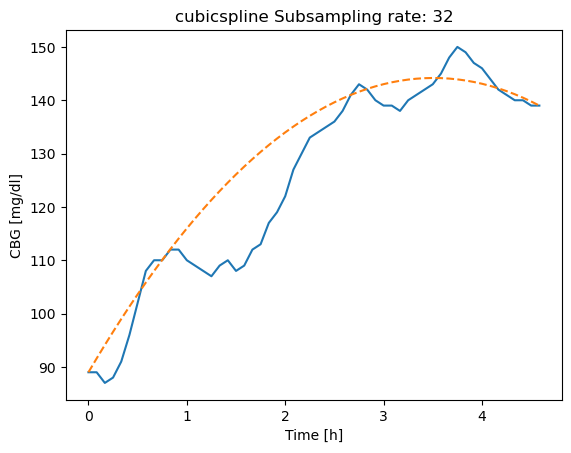

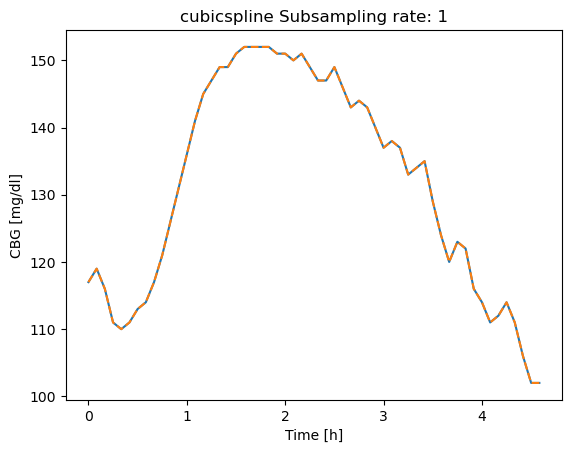

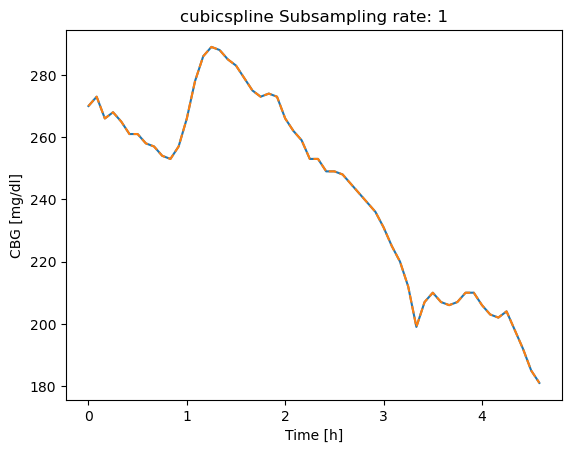

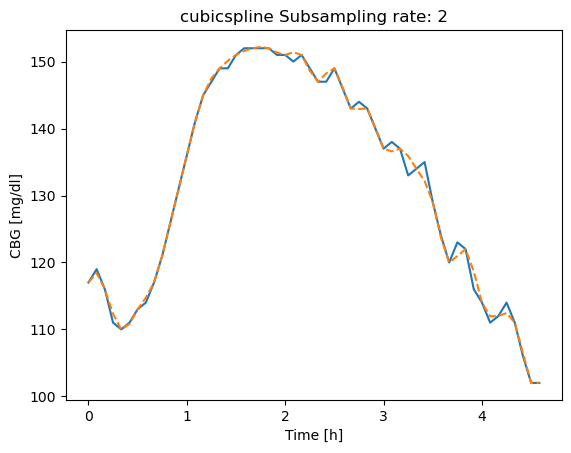

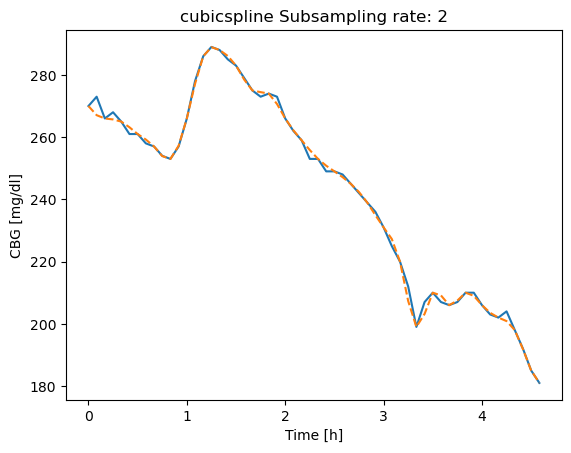

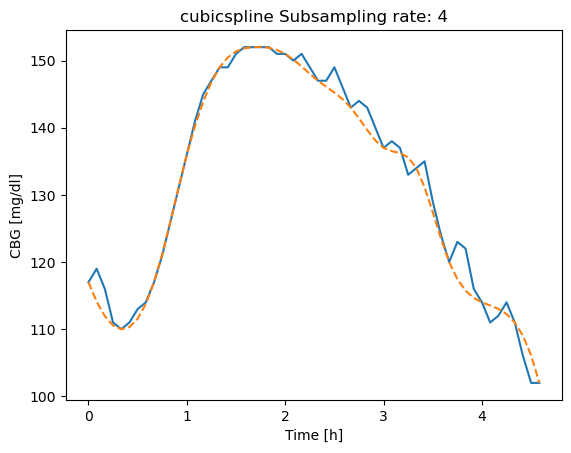

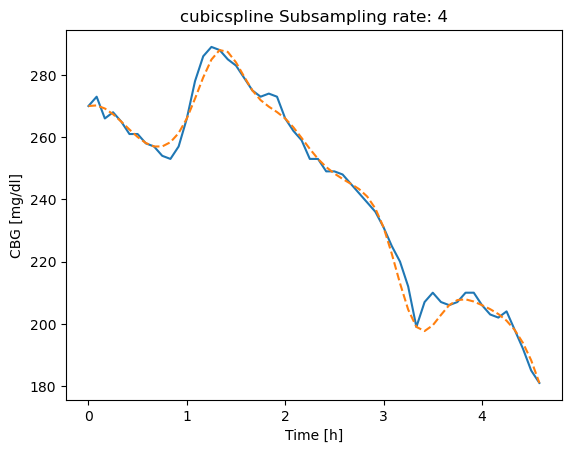

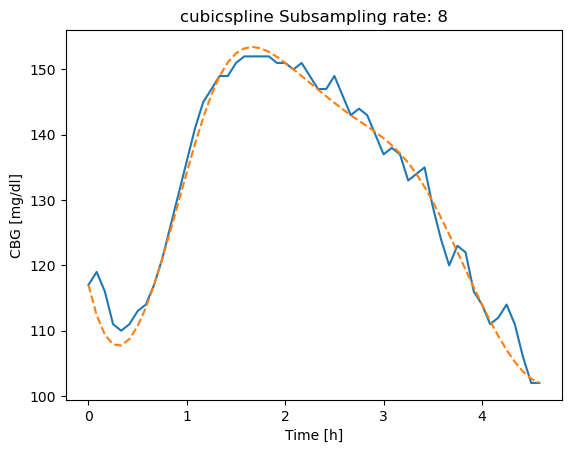

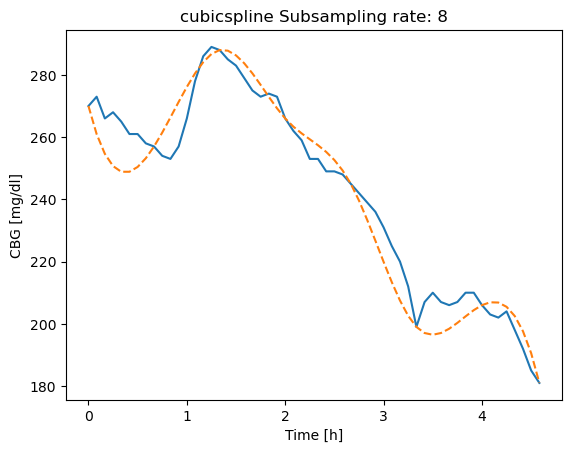

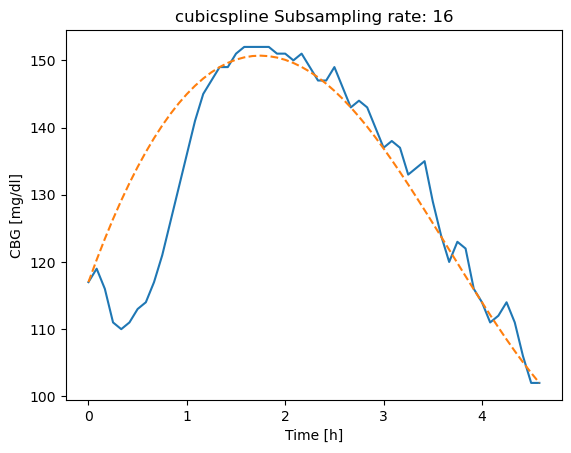

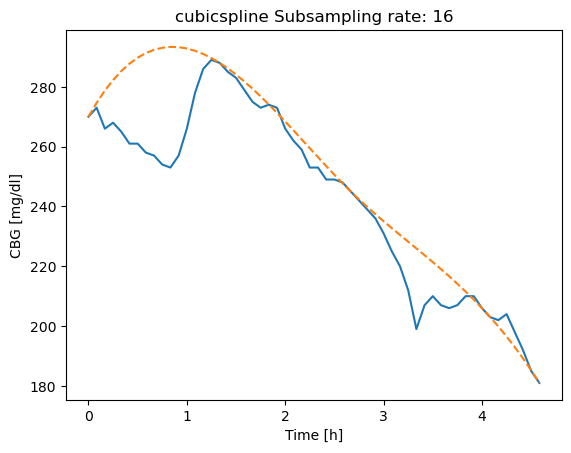

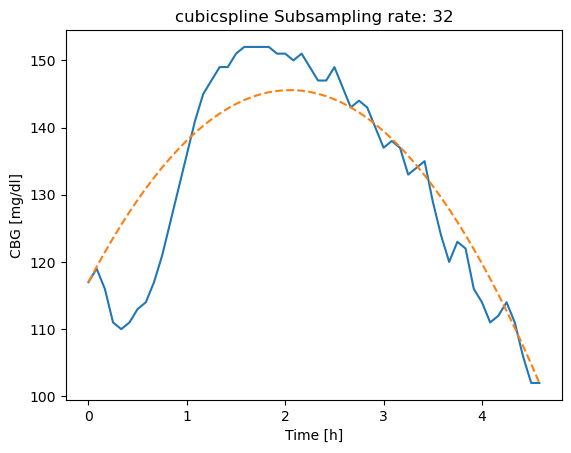

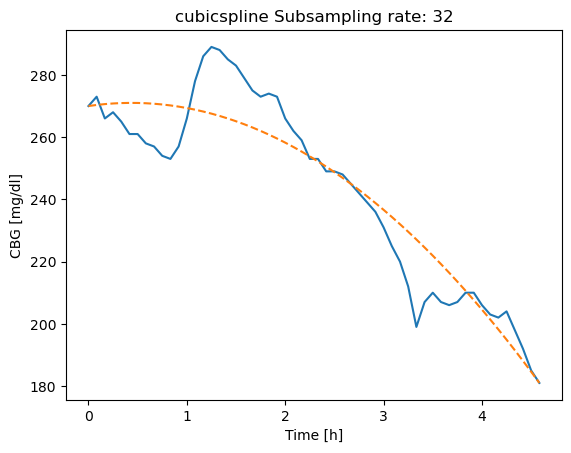

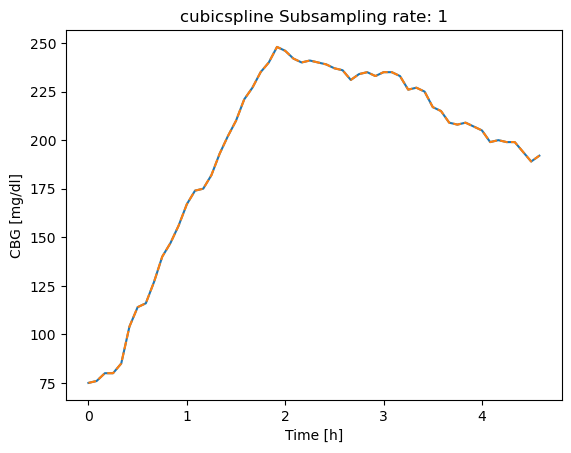

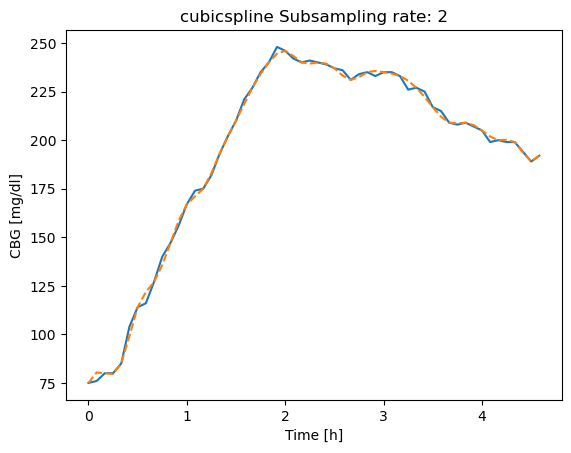

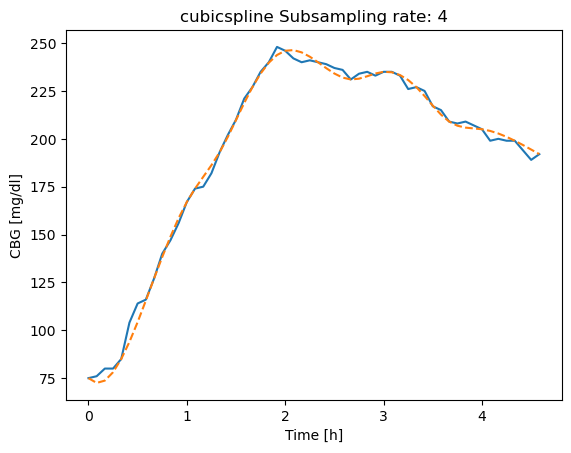

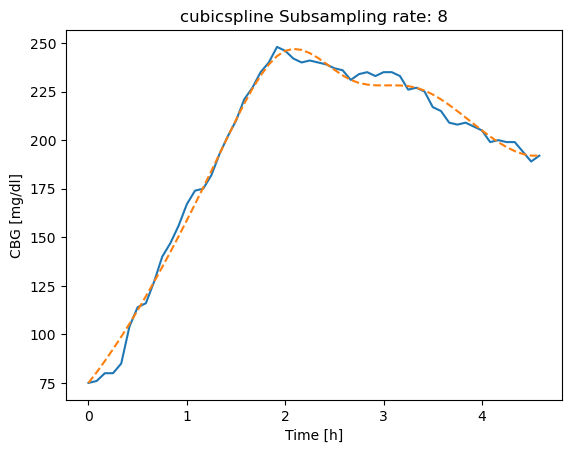

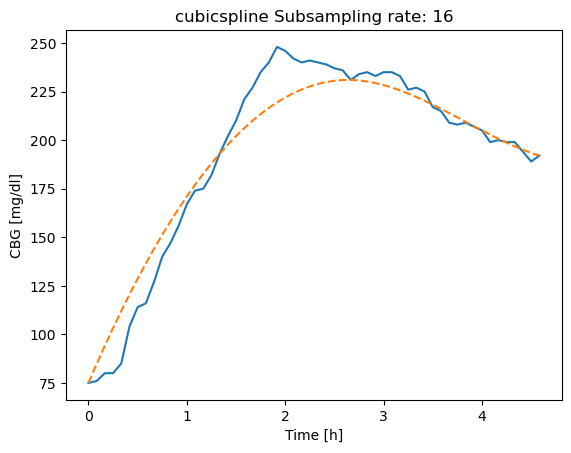

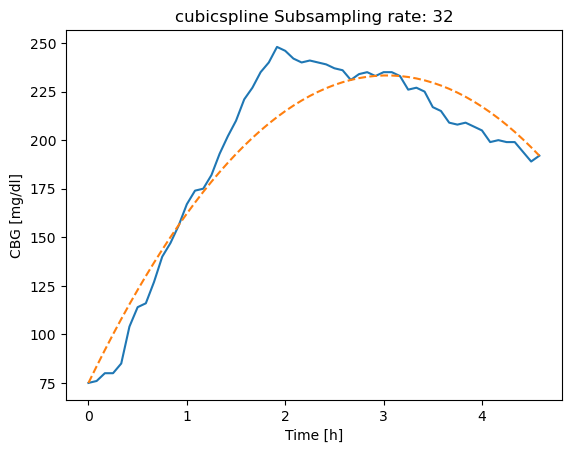

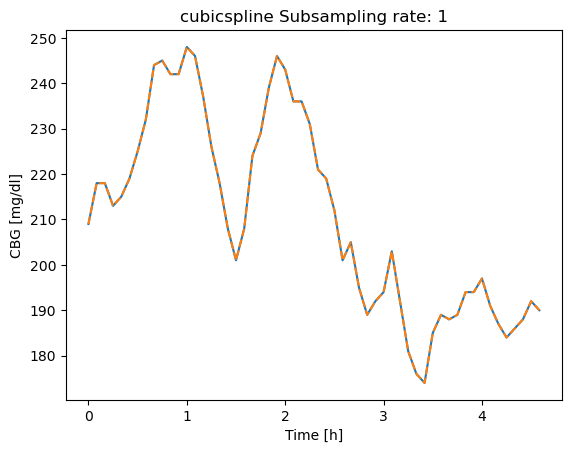

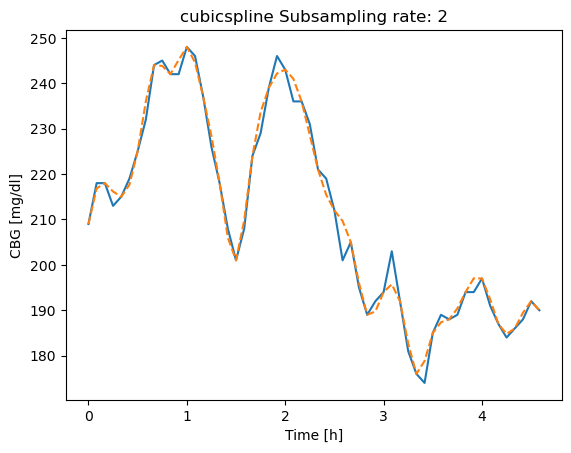

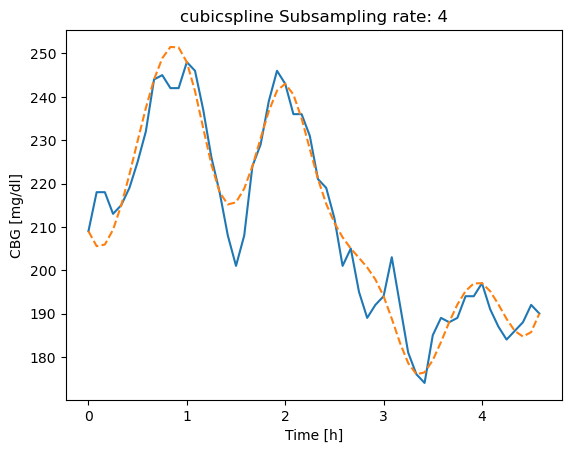

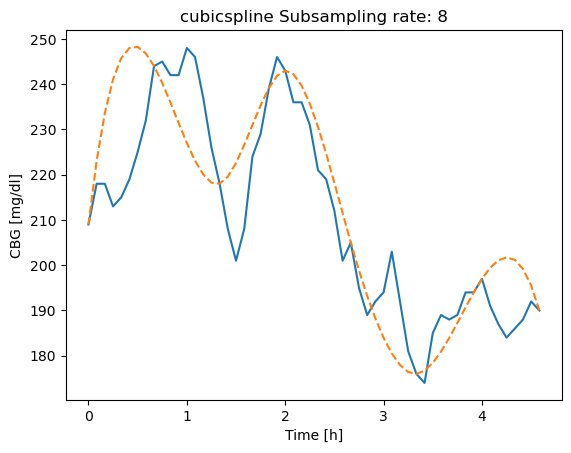

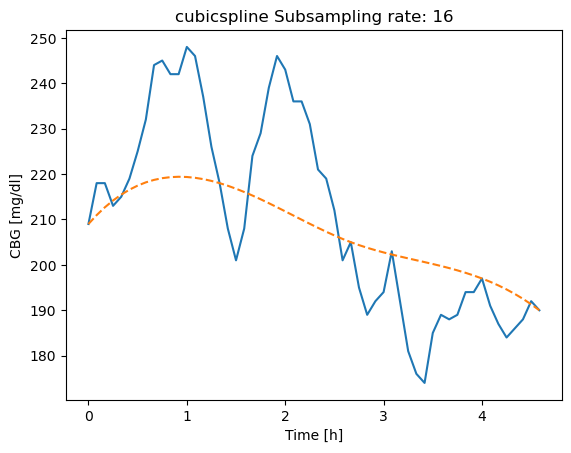

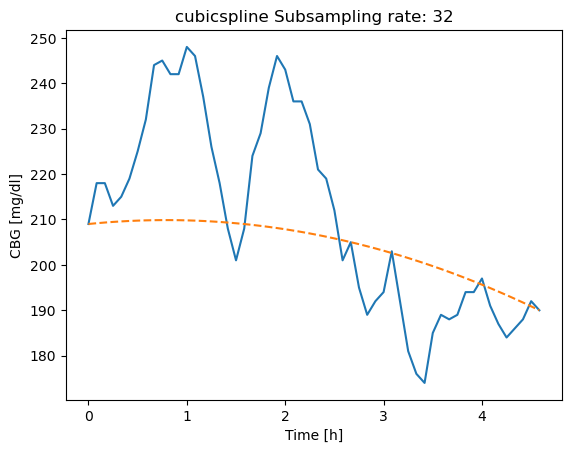

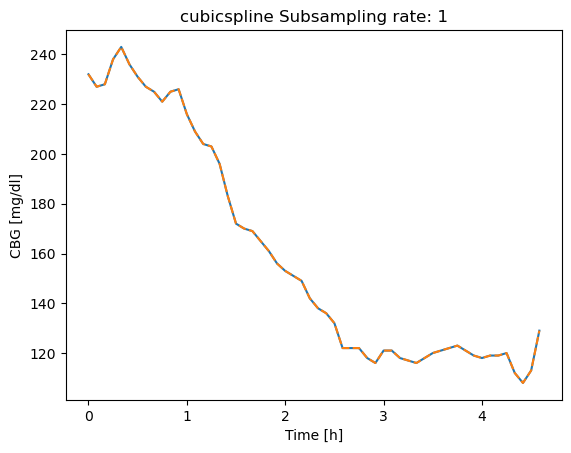

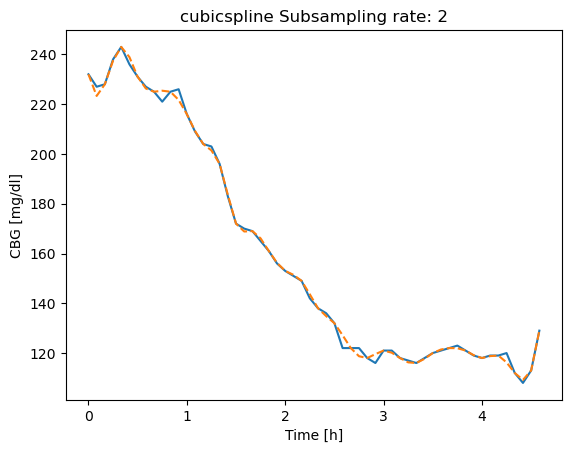

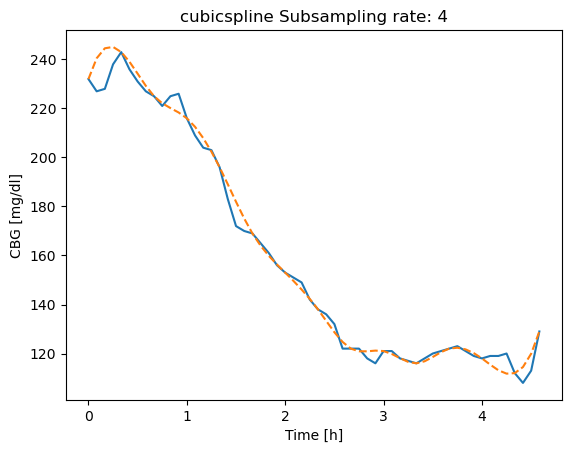

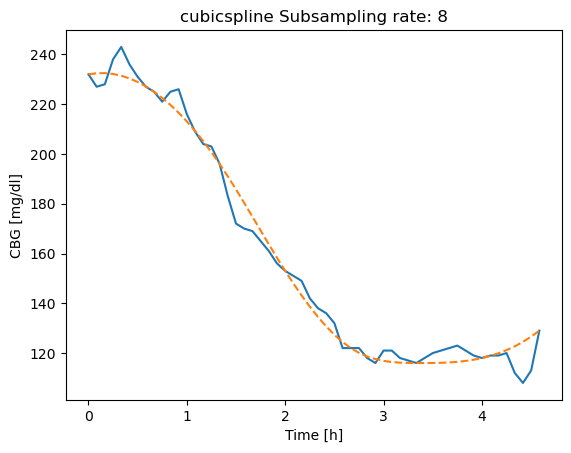

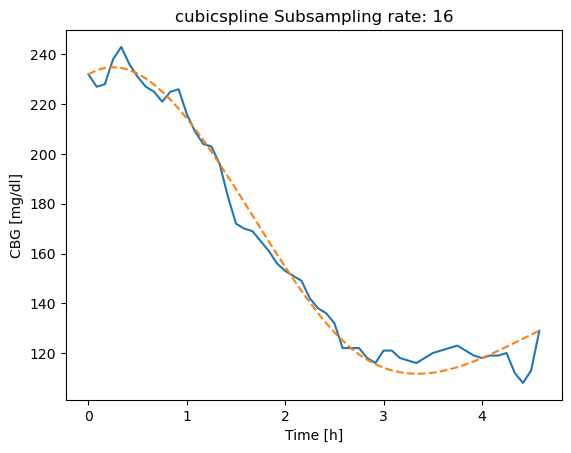

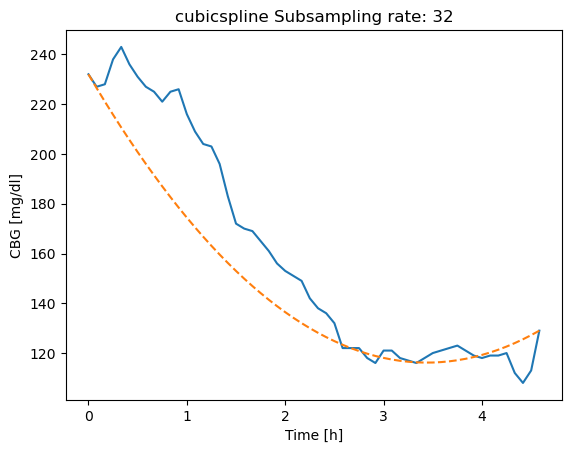

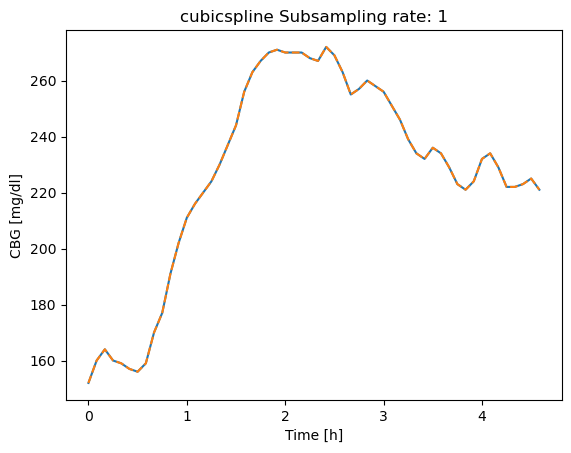

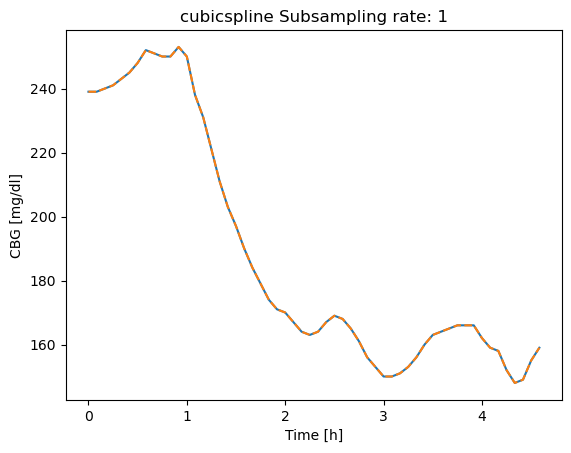

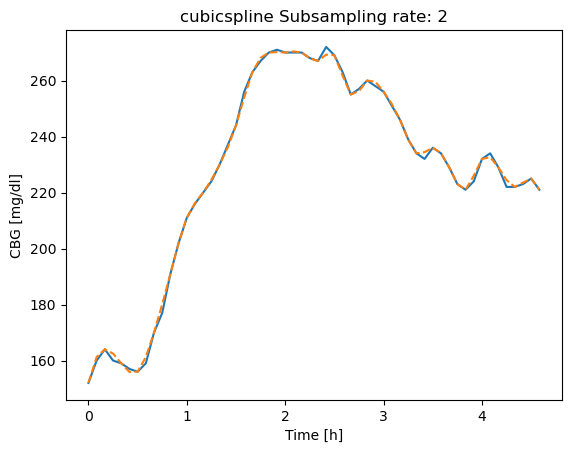

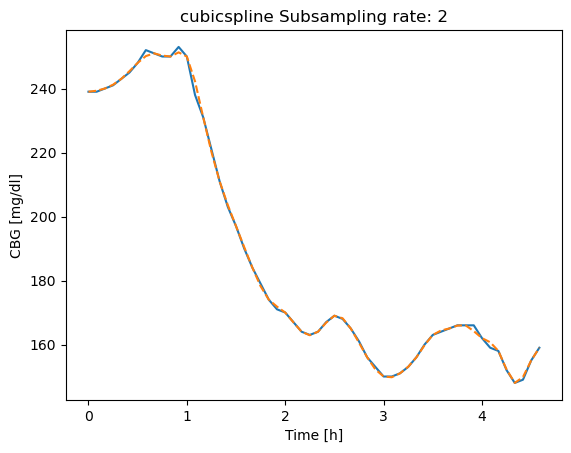

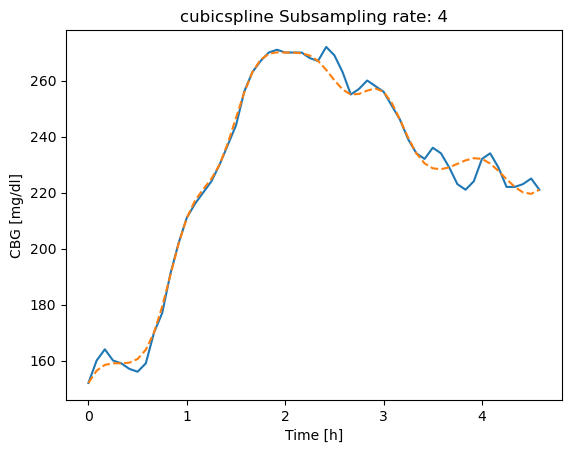

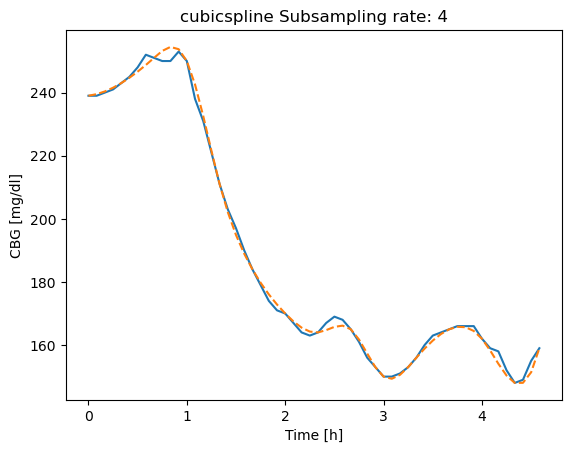

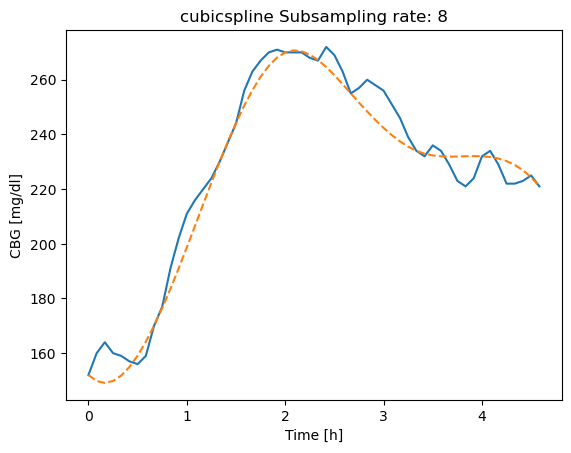

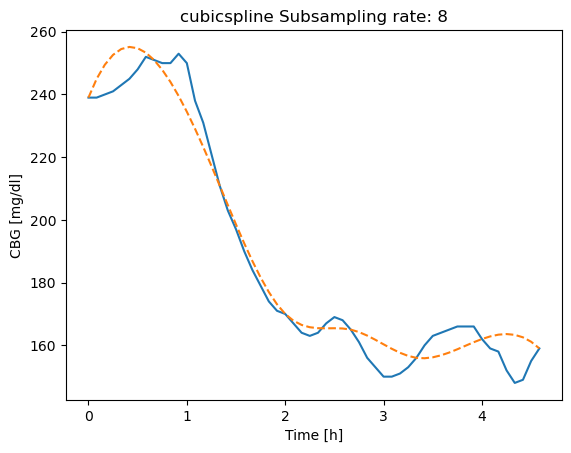

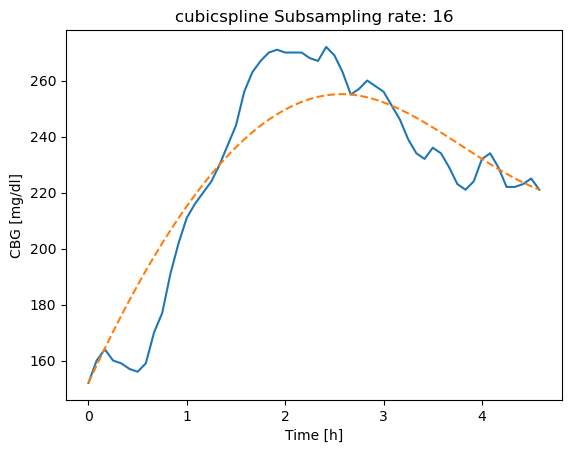

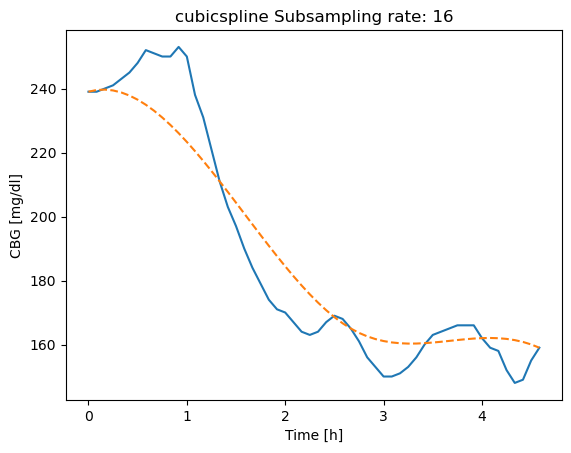

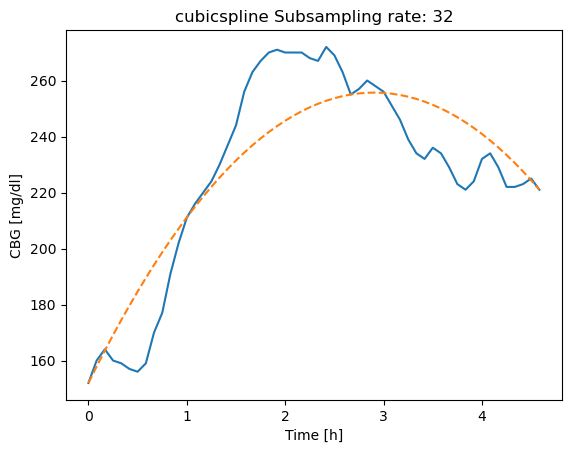

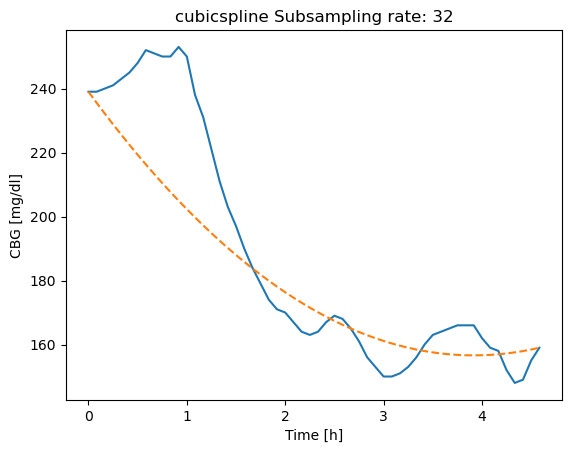

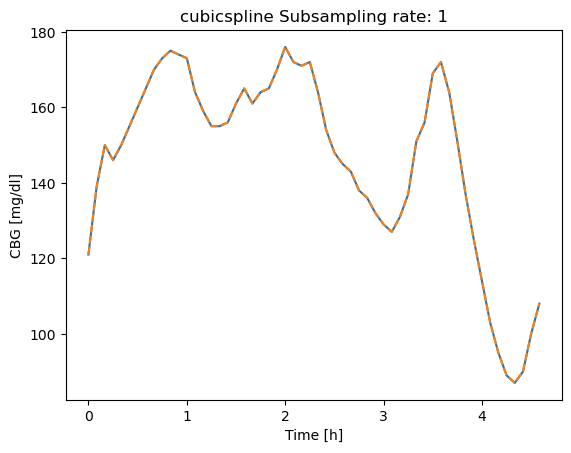

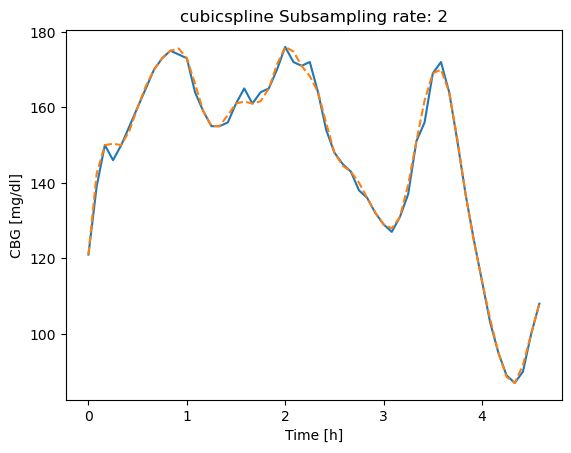

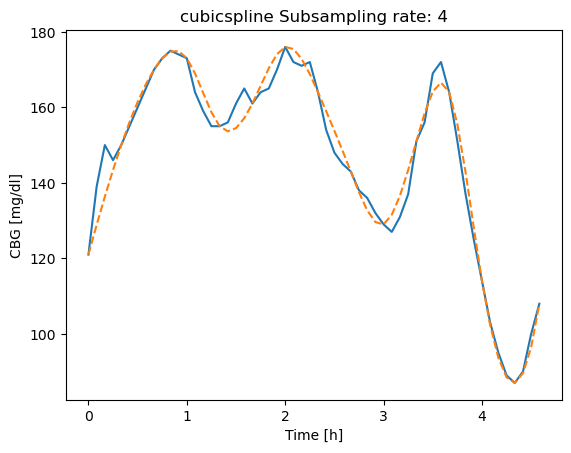

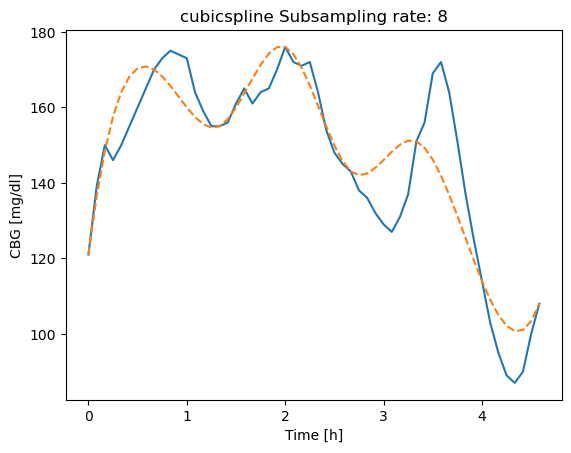

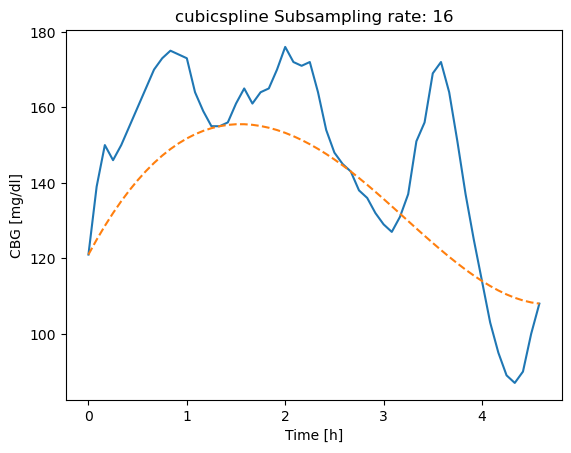

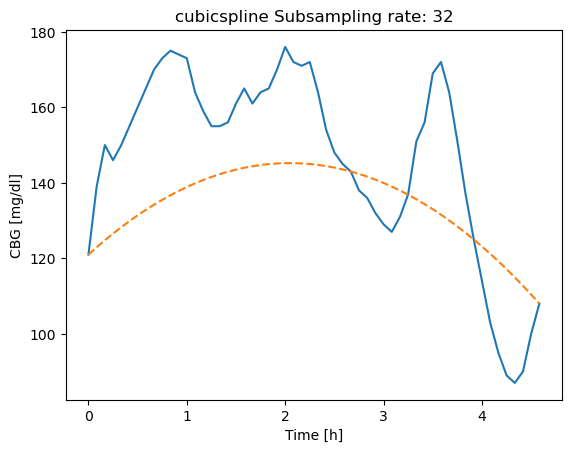

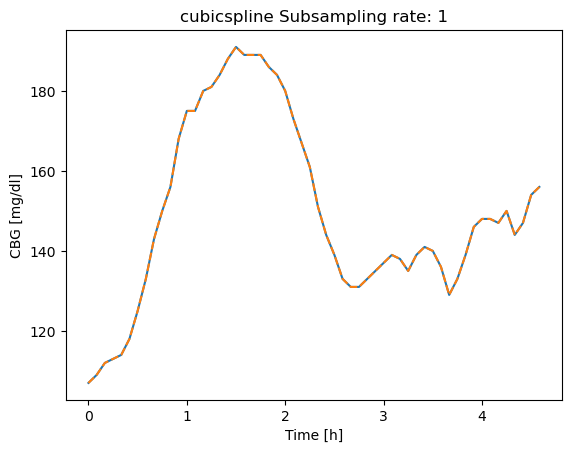

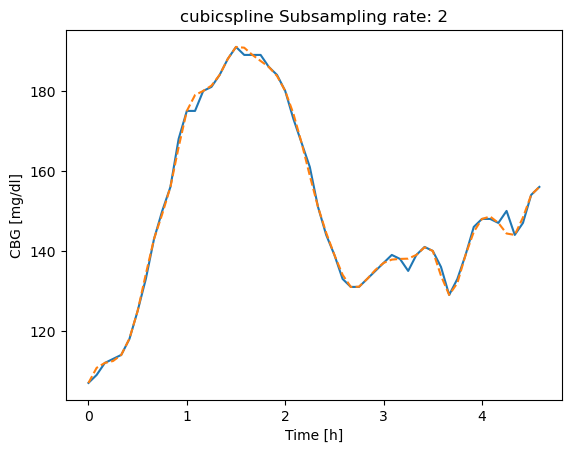

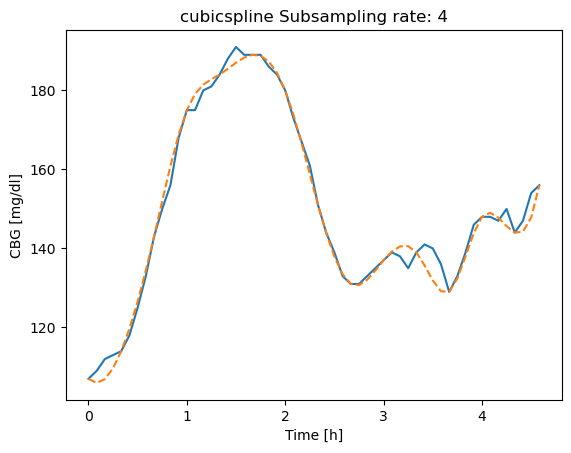

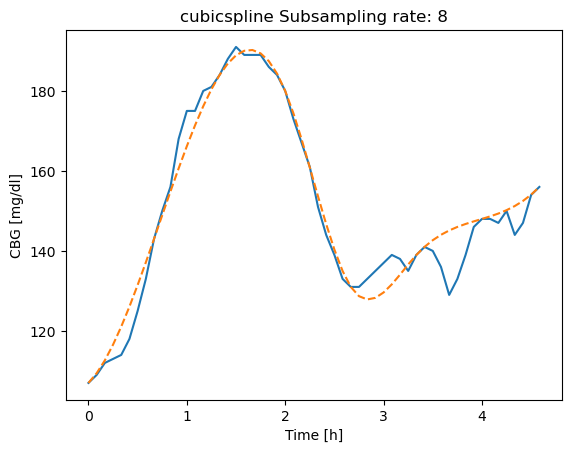

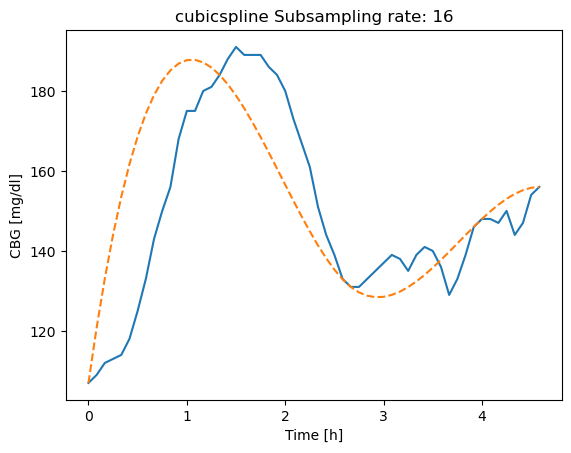

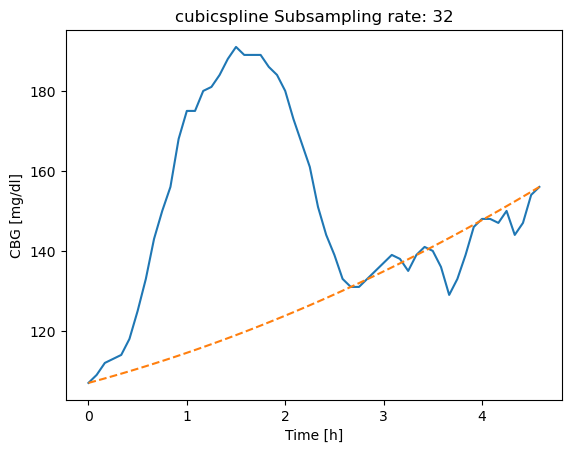

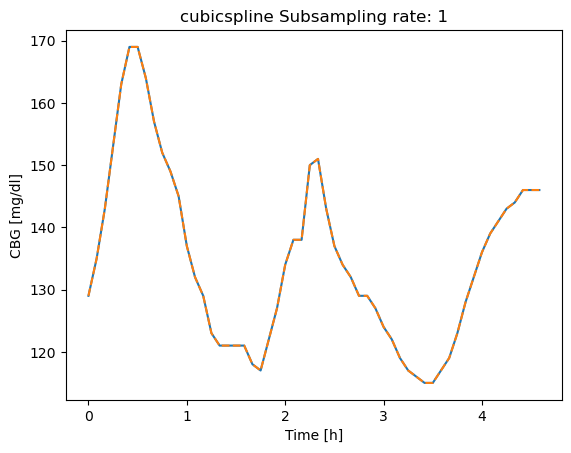

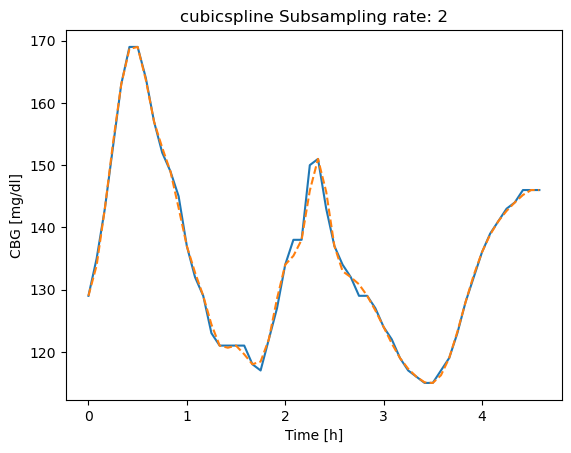

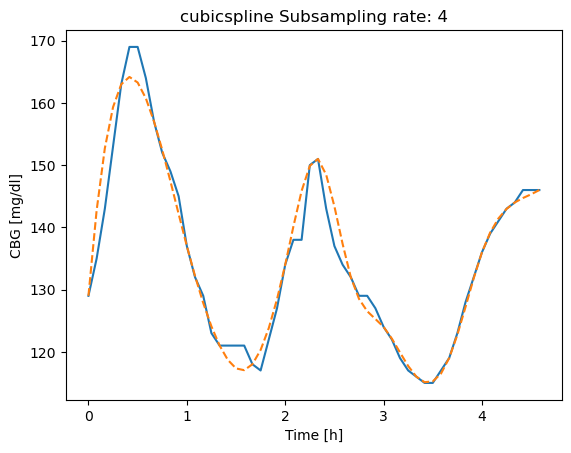

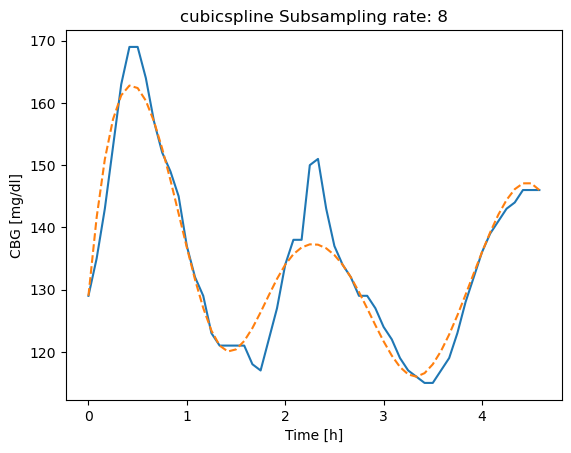

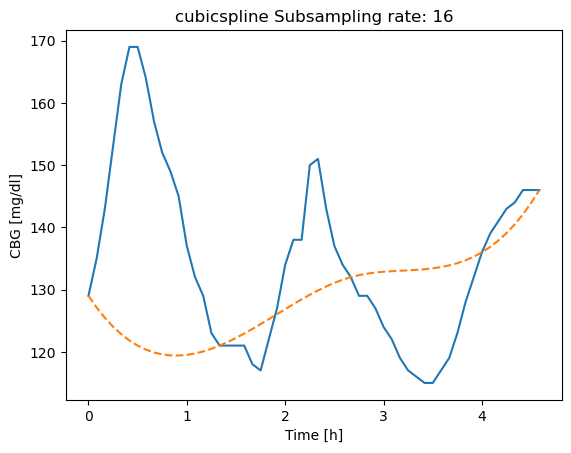

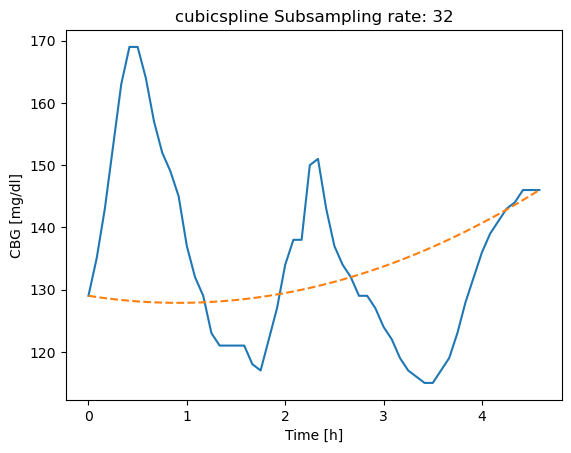

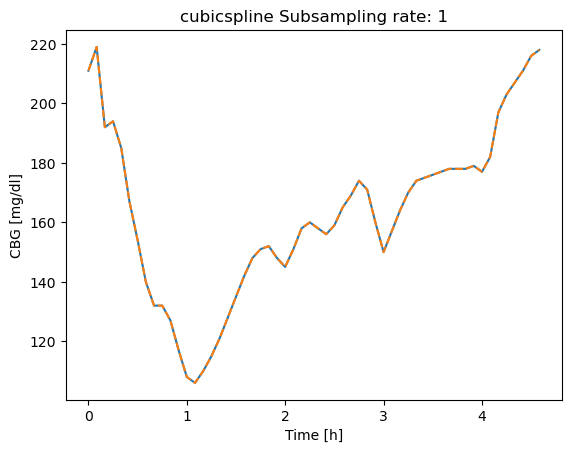

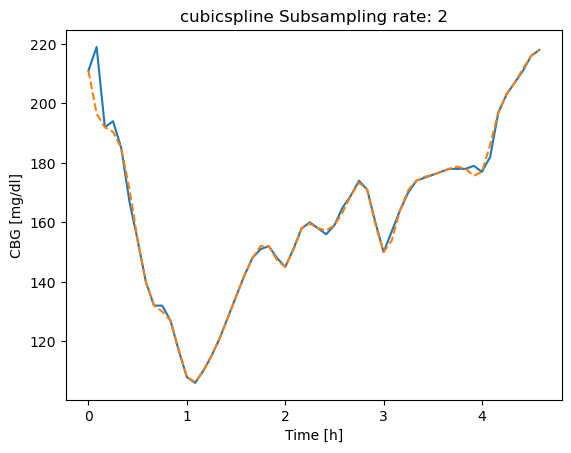

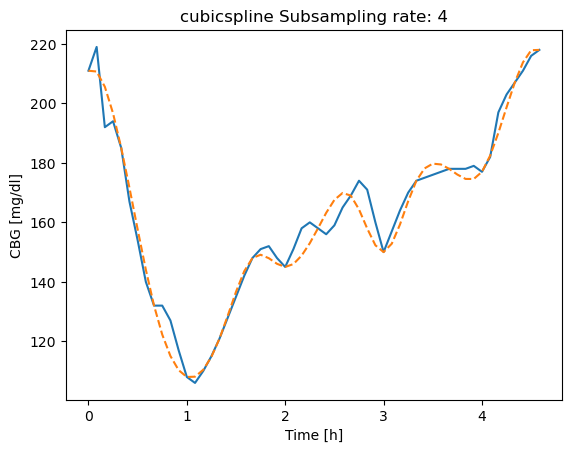

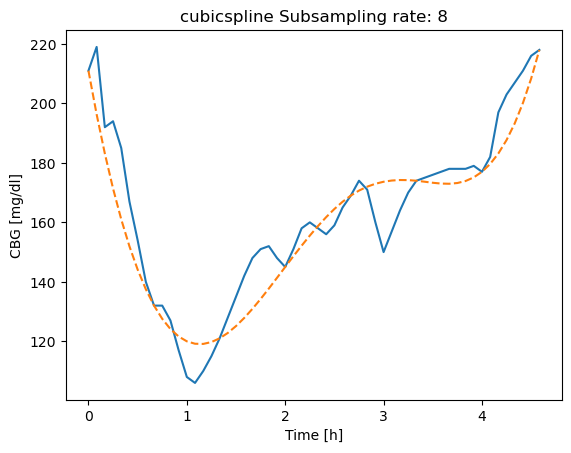

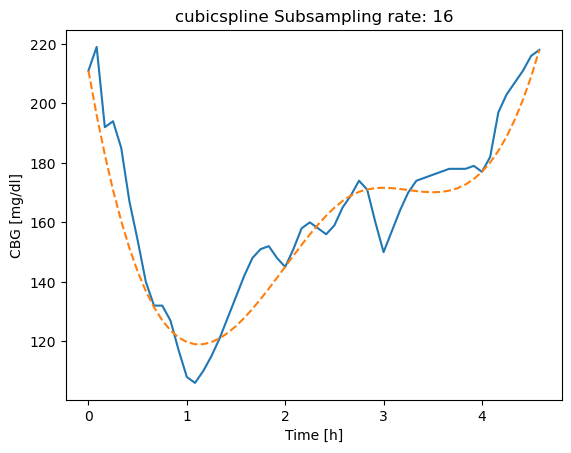

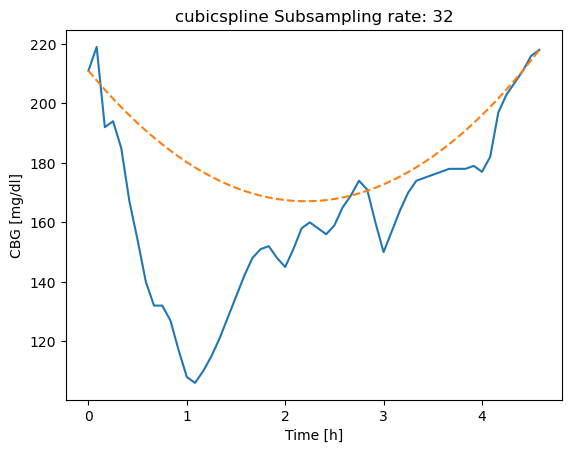

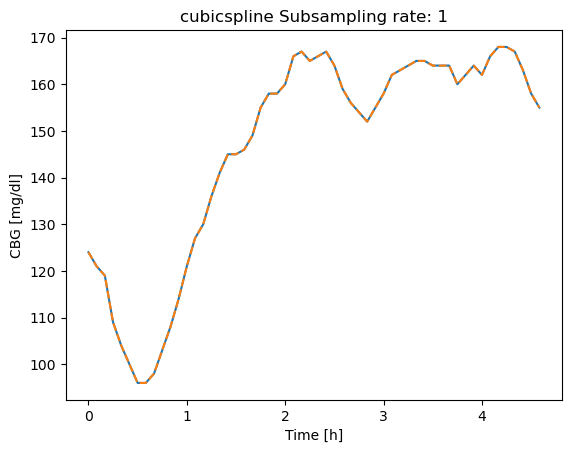

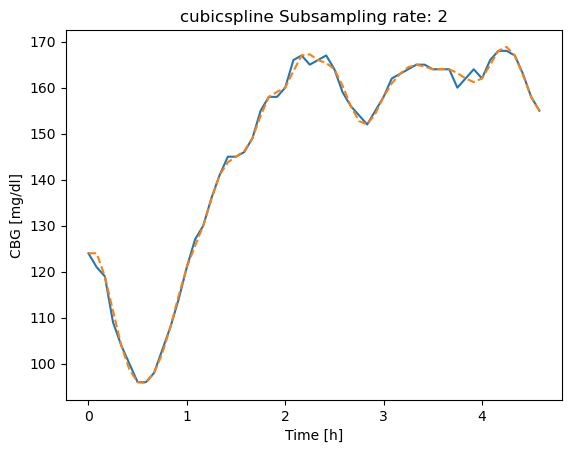

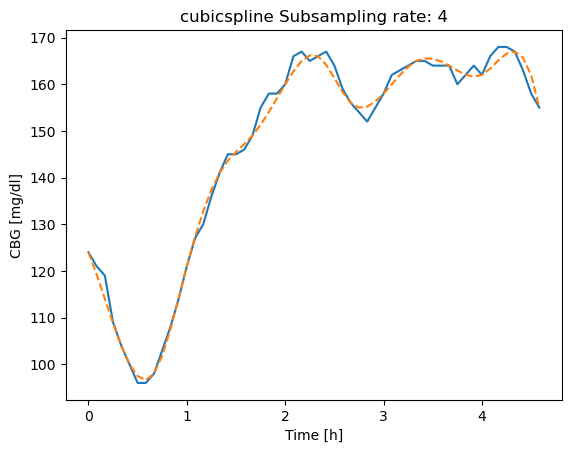

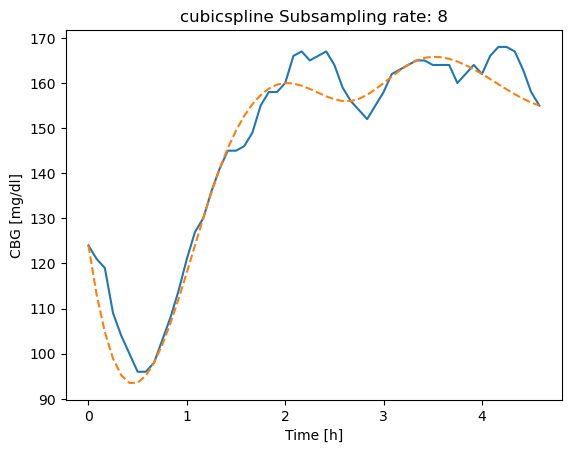

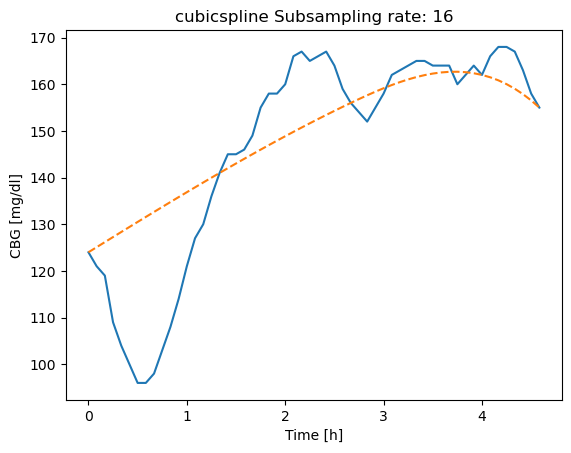

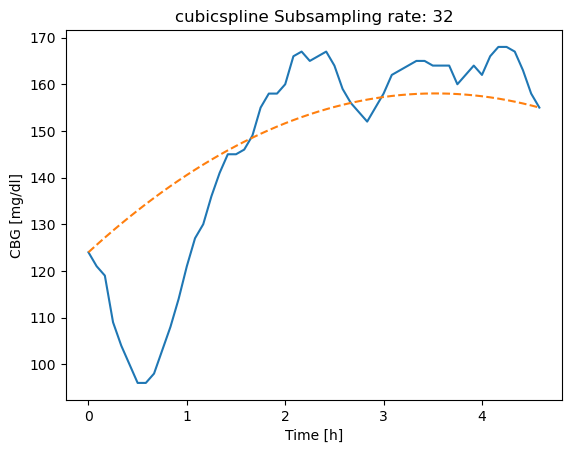

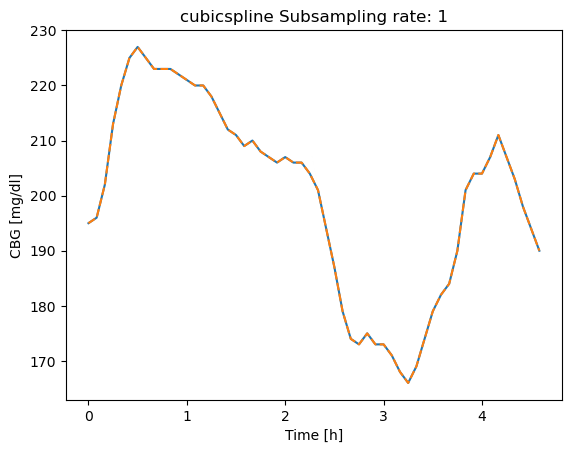

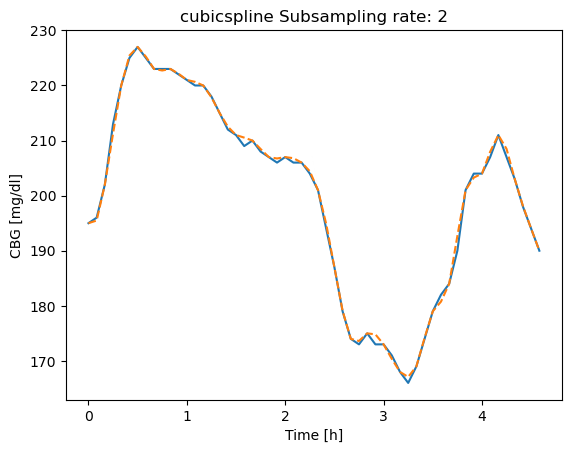

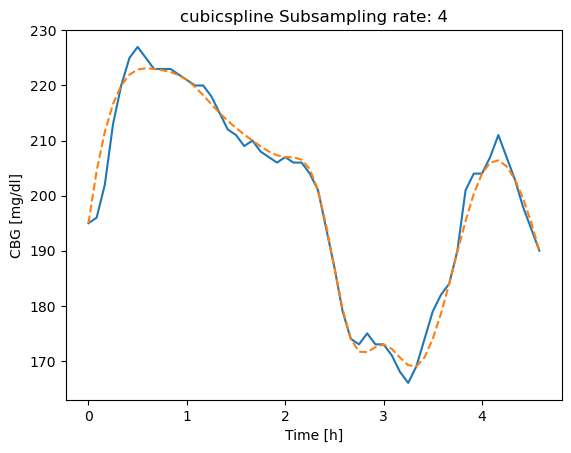

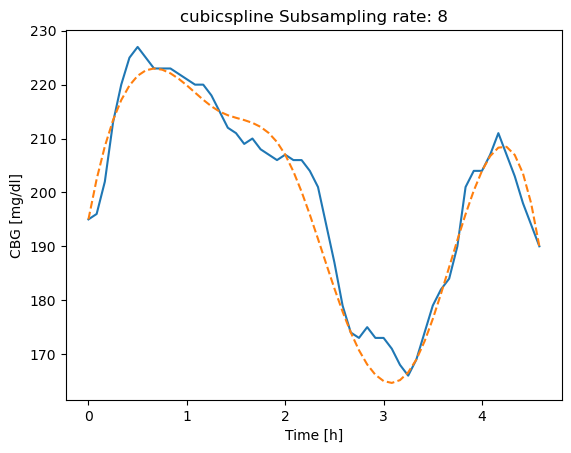

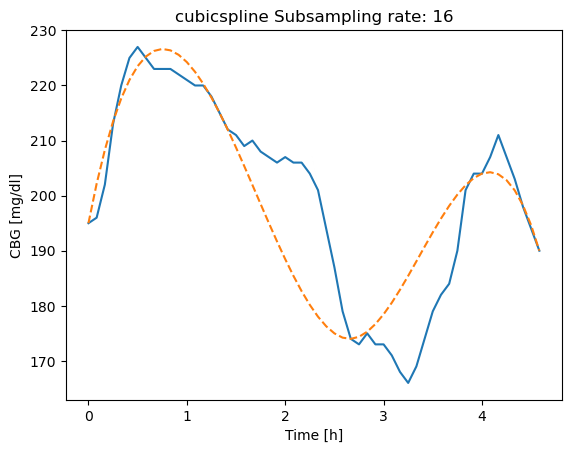

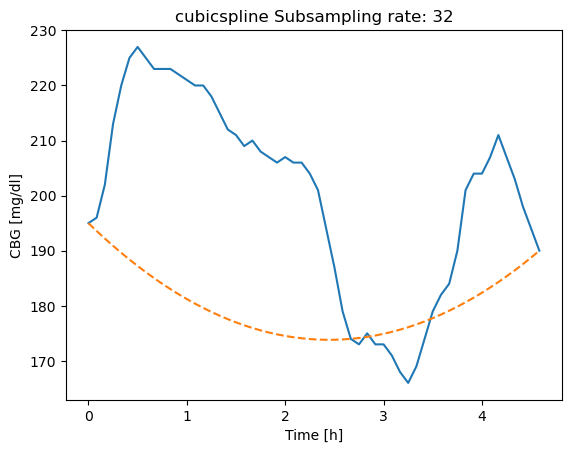

In [4]:
patients = {}
years = [2018, 2020]
for year in years:
    DATA_PATH = f"/Users/nathanhoffman/Library/Mobile Documents/com~apple~CloudDocs/UniBe/3. Semester/Data Driven Diabetes Management/DDDM-Project7/data/Ohio{year}_processed/train"
    files = os.listdir(DATA_PATH)
    for file in files:
        train_set_list, scaler = createDataSet(os.path.join(DATA_PATH, file))
        # Remove duplicates
        train_set_list = [train_set_list[x] for x, _ in enumerate(train_set_list) if train_set_list[x].equals(train_set_list[x-1]) is False]
        print(f"Length of train set: {len(train_set_list)}")
        patient_num = file.split("-")[0]
        patients[f"Patient {patient_num}"] = create_standard_metrics(train_set_list)
        

In [7]:
dfs = []
for patient in patients:
    print(patient)
    print(pd.DataFrame.from_dict(patients[patient]).T)
    dfs.append(pd.DataFrame.from_dict(patients[patient]).T)
dfs


Patient 563
                           Mean        Std  Time in range (70-180)  \
True                 153.378027  55.056905                0.727300   
Subsampling rate 1   153.378027  55.056905                0.727300   
Subsampling rate 2   153.361371  55.037780                0.725787   
Subsampling rate 4   153.313015  55.080937                0.728208   
Subsampling rate 8   153.804929  55.207597                0.722760   
Subsampling rate 16  153.046220  56.148207                0.723668   
Subsampling rate 32  152.316277  50.616382                0.762107   

                     Time in tight range (70-140)  Time in low (<70)  \
True                                     0.430387           0.018462   
Subsampling rate 1                       0.430387           0.018462   
Subsampling rate 2                       0.427058           0.019068   
Subsampling rate 4                       0.426453           0.019068   
Subsampling rate 8                       0.417978           0.01997

[                           Mean        Std  Time in range (70-180)  \
 True                 153.378027  55.056905                0.727300   
 Subsampling rate 1   153.378027  55.056905                0.727300   
 Subsampling rate 2   153.361371  55.037780                0.725787   
 Subsampling rate 4   153.313015  55.080937                0.728208   
 Subsampling rate 8   153.804929  55.207597                0.722760   
 Subsampling rate 16  153.046220  56.148207                0.723668   
 Subsampling rate 32  152.316277  50.616382                0.762107   
 
                      Time in tight range (70-140)  Time in low (<70)  \
 True                                     0.430387           0.018462   
 Subsampling rate 1                       0.430387           0.018462   
 Subsampling rate 2                       0.427058           0.019068   
 Subsampling rate 4                       0.426453           0.019068   
 Subsampling rate 8                       0.417978           0.01

TypeError: Legend.__init__() got an unexpected keyword argument 'location'

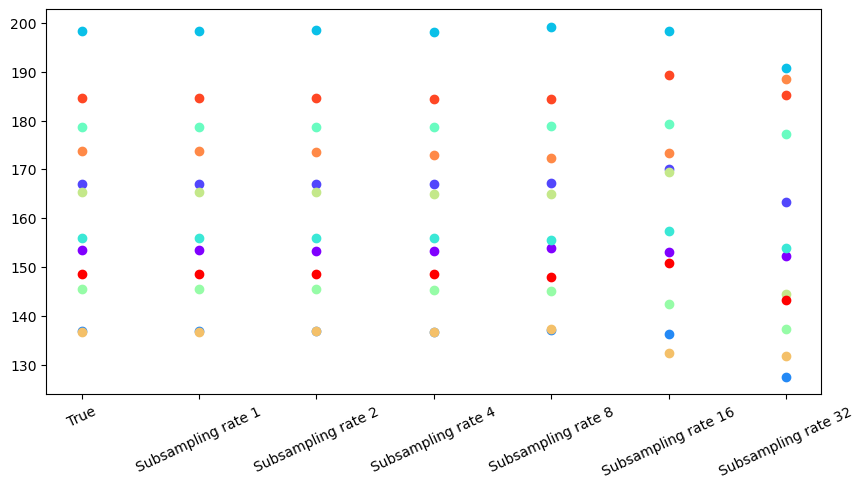

In [ ]:
color = plt.cm.rainbow(np.linspace(0, 1, len(dfs)))
fig = plt.figure(figsize=(10,5))
for i, (c, patient) in enumerate(zip(color, patients)):
   plt.plot(dfs[i]["Mean"], "o",label=f"{patient}", c=c)
plt.xticks(rotation=25)
plt.legend(bbox_to_anchor=(1.1, 1.05))
